## Overview of LOAN Application Data API
Banks deal in all home loans. They have a presence across all urban, semi-urban, and rural
areas. Customers first apply for a home loan; after that, a company will validate the customer's
eligibility for a loan.
Banks want to automate the loan eligibility process (in realtime) based on customer details
provided while filling out the online application form. These details are Gender, Marital Status,
Education, Number of Dependents, Income, Loan Amount, Credit History, and others. To
automate this process, they have the task of identifying the customer segments to those who
are eligible for loan amounts so that they can specifically target these customers. Here they
have provided a partial dataset.
API Endpoint:
https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json
The above URL allows you to access information for loan application information. This dataset
has all of the required fields for a loan application. You can access data from a REST API by
sending an HTTP request and processing the response

In [2]:
import sys
import json
import requests
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType,VarcharType,TimestampType,StringType

## Data Extraction

Reading api data using request library

Functional
Requirements 4.1
Create a Python program to GET (consume) data from the above API
endpoint for the loan application dataset.

In [4]:
api_url='https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response=requests.get(api_url)
print(response.status_code)
if response.status_code == 200:
    r= response.json()
else:
       None

Writing the data to the file

In [8]:
with open('../PROGRAMFILES/loan_data.json', 'w') as file:
    json.dump(r, file)
   

Starting a spark Session 

In [3]:
spark = SparkSession.builder.appName("CreditCardSystemApp").master("local[*]").getOrCreate()

Reading data from the json file and printing the schema

In [11]:
df_schema=spark.read.json("loan_data.json")
df_schema.printSchema()
df_schema.show(5)

root
 |-- Application_ID: string (nullable = true)
 |-- Application_Status: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Self_Employed: string (nullable = true)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    G

Writing to the creditcard_capstone database

Functional
Requirements 4.3
Once Python reads data from the API, utilize PySpark to load data into
RDBMS (SQL). The table name should be CDW-SAPP_loan_application
in the database.


In [12]:
df_schema.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
   .save()


## Data Visualization

Functional
Requirements 5.1
Find and plot the percentage of applications approved for self-employed
applicants.


In [13]:
data_loan_data=spark.read.format("jdbc") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable","creditcard_capstone.CDW_SAPP_loan_application" ) \
        .option("user", "root") \
        .option("password", "password")\
        .load()

Creating a tempview for the CDW_SAPP_loan_application table

In [4]:
data_loan_data.createOrReplaceTempView("Loan_table")

Select all the data from the table and converting to pandas dataframe

In [5]:
df_loan_table=spark.sql("select * from Loan_table")
df_approved_perc=df_loan_table.toPandas()

In [6]:
df_approved_perc

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Y,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,N,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Y,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Y,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Y,1,0,Graduate,Male,medium,No,Urban,No
...,...,...,...,...,...,...,...,...,...,...
506,LP002978,Y,1,0,Graduate,Female,low,No,Rural,No
507,LP002979,Y,1,3+,Graduate,Male,medium,Yes,Rural,No
508,LP002983,Y,1,1,Graduate,Male,medium,Yes,Urban,No
509,LP002984,Y,1,2,Graduate,Male,medium,Yes,Urban,No


Selecting the required fiels for the visualization

In [7]:
df_selfemployed=df_approved_perc[['Application_Status','Self_Employed']].value_counts()

In [8]:
df_selfemployed

Application_Status  Self_Employed
Y                   No               301
N                   No               140
Y                   Yes               46
N                   Yes               24
Name: count, dtype: int64

Functional
Requirements 5.1
Find and plot the percentage of applications approved for self-employed
applicants.

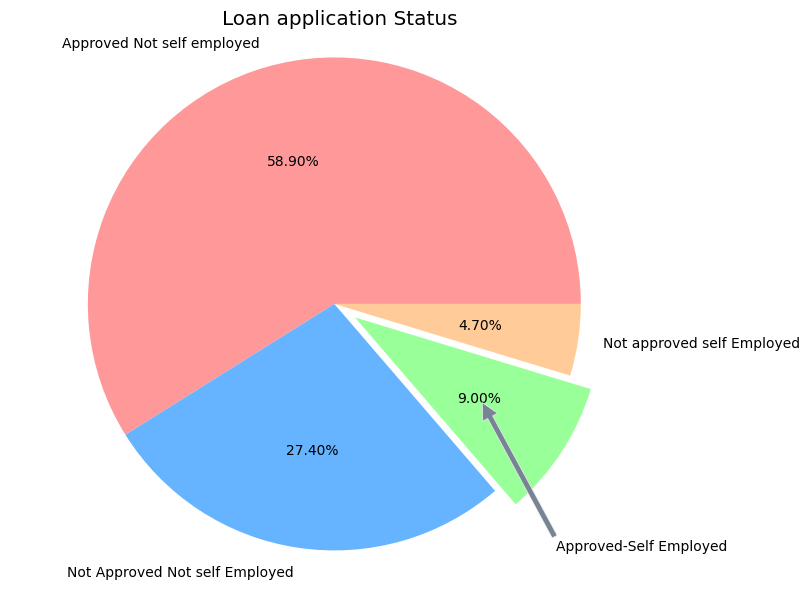

In [46]:
plt.rcParams["figure.figsize"] = [8, 6]
explode=(0,0,0.1,0)

plt.style.use('ggplot')
labels=['Approved Not self employed','Not Approved Not self Employed','','Not approved self Employed']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffb3e6', '#c2c2f0','#ffb3e6','#ff6666']
plt.pie(df_selfemployed,autopct='%.2f%%',explode=explode,startangle=0,colors=colors,labels=labels)
plt.axis('equal')
plt.title("Loan application Status")
plt.gca().annotate("Approved-Self Employed ",  xy=(.6, -.4), xytext=(0.9, - 1.0),arrowprops=dict(facecolor='#768493'))

plt.show()

Functional
Requirements 5.2\
Find the percentage of rejection for married male applicants.


In [22]:
df_married_gender=df_approved_perc[['Married','Application_Status','Gender']].value_counts()
df_married_gender

Married  Application_Status  Gender
Yes      Y                   Male      219
         N                   Male       87
No       Y                   Male       71
         N                   Male       43
         Y                   Female     40
         N                   Female     26
Yes      Y                   Female     17
         N                   Female      8
Name: count, dtype: int64

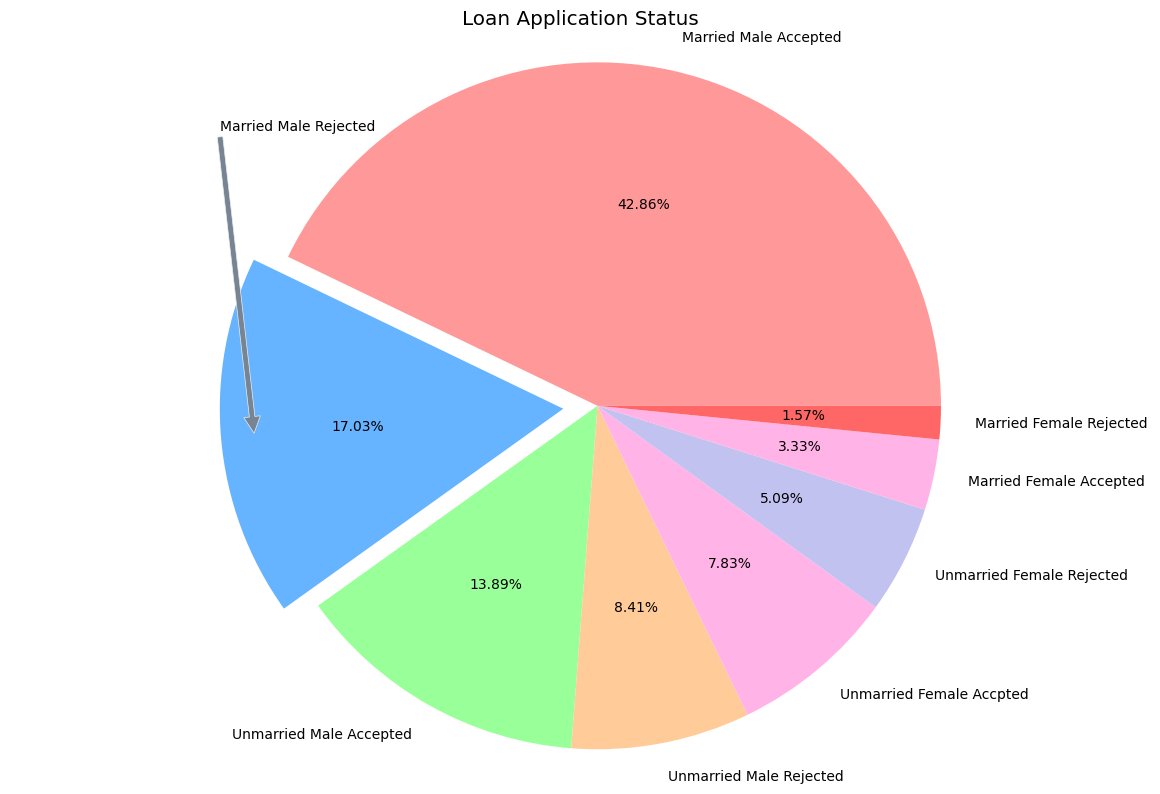

In [47]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True
explode=(0,0.1,0,0,0,0,0,0)
plt.style.use('ggplot')
labels=['Married Male Accepted','','Unmarried Male Accepted','Unmarried Male Rejected','Unmarried Female Accpted','Unmarried Female Rejected','Married Female Accepted','Married Female Rejected']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffb3e6', '#c2c2f0','#ffb3e6','#ff6666']
plt.pie(df_married_gender,autopct='%.2f%%',explode=explode,startangle=0,colors=colors,labels=labels)
plt.axis('equal')

plt.gca().annotate("Married Male Rejected", xy=(-1.0, -0.08), xytext=(-1.1,  0.8),arrowprops=dict(facecolor='#768493'))
plt.title("Loan Application Status")
plt.show()

Functional
Requirements 5.3\
Find and plot the top three months with the largest transaction data.


In [7]:

data_transaction_data=spark.read.format("jdbc") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable","creditcard_capstone.CDW_SAPP_credit_card" ) \
        .option("user", "root") \
        .option("password", "password")\
        .load()

In [8]:
data_transaction_data.dtypes

[('BRANCH_CODE', 'int'),
 ('CUST_SSN', 'int'),
 ('TRANSACTION_ID', 'int'),
 ('TRANSACTION_TYPE', 'string'),
 ('TRANSACTION_VALUE', 'double'),
 ('CUST_CC_NO', 'string'),
 ('TIMEID', 'timestamp')]

In [9]:
data_transaction_data.createOrReplaceTempView("Transaction_table")

In [10]:
df_transaction=spark.sql("select * from Transaction_table")

In [11]:
df_transaction.show()

+-----------+---------+--------------+----------------+-----------------+----------------+-------------------+
|BRANCH_CODE| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|      CUST_CC_NO|             TIMEID|
+-----------+---------+--------------+----------------+-----------------+----------------+-------------------+
|        156|123455692|         22562|         Grocery|            91.08|4210653312478046|2018-08-13 00:00:00|
|        180|123451310|         45069|           Bills|            77.79|4210653342242023|2018-03-15 00:00:00|
|        114|123459988|             1|       Education|             78.9|4210653349028689|2018-02-14 00:00:00|
|        114|123455692|         22563|           Bills|             22.2|4210653312478046|2018-06-26 00:00:00|
|        107|123451310|         45070|      Healthcare|            20.47|4210653342242023|2018-04-19 00:00:00|
|         35|123459988|             2|   Entertainment|            14.24|4210653349028689|2018-03-20 00:00:00|
|

In [28]:
type(df_transaction)


pyspark.sql.dataframe.DataFrame

In [12]:
df_transaction=df_transaction.withColumn('TIMEID', func.to_date(df_transaction["TIMEID"]))

In [13]:
df_transaction.dtypes

[('BRANCH_CODE', 'int'),
 ('CUST_SSN', 'int'),
 ('TRANSACTION_ID', 'int'),
 ('TRANSACTION_TYPE', 'string'),
 ('TRANSACTION_VALUE', 'double'),
 ('CUST_CC_NO', 'string'),
 ('TIMEID', 'date')]

In [14]:
df_transaction.createOrReplaceTempView("Transaction_table")

In [32]:
df_transaction.show()

+-----------+---------+--------------+----------------+-----------------+----------------+----------+
|BRANCH_CODE| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|      CUST_CC_NO|    TIMEID|
+-----------+---------+--------------+----------------+-----------------+----------------+----------+
|        156|123455692|         22562|         Grocery|            91.08|4210653312478046|2018-08-13|
|        180|123451310|         45069|           Bills|            77.79|4210653342242023|2018-03-15|
|        114|123459988|             1|       Education|             78.9|4210653349028689|2018-02-14|
|        114|123455692|         22563|           Bills|             22.2|4210653312478046|2018-06-26|
|        107|123451310|         45070|      Healthcare|            20.47|4210653342242023|2018-04-19|
|         35|123459988|             2|   Entertainment|            14.24|4210653349028689|2018-03-20|
|         47|123455692|         22564|         Grocery|            77.54|421065331

Functional
Requirements 5.3
Find and plot the top three months with the largest transaction data.
Note: Take a screenshot of the graph.

In [15]:
top3transaction=spark.sql("select MONTH(TIMEID) AS month,count(*) as count from Transaction_table  group by month(TIMEID) order by 2 DESC limit 3")

In [35]:
top3transaction.show()

+-----+-----+
|month|count|
+-----+-----+
|    2| 3959|
|    5| 3946|
|   10| 3946|
+-----+-----+



In [36]:
top3transaction=top3transaction.toPandas()

In [125]:
top3transaction

,month,count
0,2,3959
1,5,3946
2,10,3946


Converting month to string for plotting continously

In [37]:
top3transaction['month']=top3transaction['month'].apply(str)
top3transaction=top3transaction.sort_values('count')

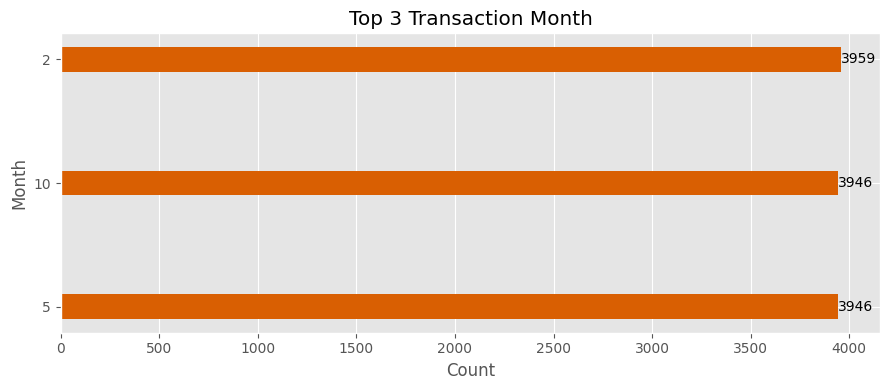

In [38]:
fig, ax = plt.subplots(figsize=(9,4))
colors=['#d95f02']
g=ax.barh(top3transaction['month'], top3transaction['count'],color=colors,height=.2)
ax.set_xlabel("Count")
ax.set_ylabel("Month")
ax.bar_label(g, label_type="edge") 

plt.title("Top 3 Transaction Month")

plt.yticks(top3transaction['month'])
plt.tight_layout()
plt.show()

Functional
Requirements 5.4\
Find and plot which branch processed the highest total dollar value of
healthcare transactions.

In [16]:
tophealthtransaction=spark.sql("""select BRANCH_CODE AS BranchCode,round(sum(TRANSACTION_VALUE)) AS TotalTransactionAmount FROM Transaction_table
                               where TRANSACTION_TYPE='Healthcare' group by BRANCH_CODE,TRANSACTION_TYPE order by 2 desc limit 10""")

In [17]:
tophealthtransaction.show()

+----------+----------------------+
|BranchCode|TotalTransactionAmount|
+----------+----------------------+
|        25|                4370.0|
|        60|                4072.0|
|        83|                4003.0|
|        36|                3824.0|
|       111|                3720.0|
|        90|                3697.0|
|        21|                3652.0|
|       109|                3604.0|
|        42|                3603.0|
|        70|                3594.0|
+----------+----------------------+



In [105]:
tophealthtransaction.dtypes

[('BranchCode', 'int'), ('TotalTransactionAmount', 'double')]

In [18]:
tophealthtransaction=tophealthtransaction.toPandas()

In [21]:
tophealthtransaction['BranchCode']=tophealthtransaction['BranchCode'].apply(str)
tophealthtransaction=tophealthtransaction.sort_values('TotalTransactionAmount',ascending=False)

In [22]:
tophealthtransaction

,BranchCode,TotalTransactionAmount
0,25,4370.0
1,60,4072.0
2,83,4003.0
3,36,3824.0
4,111,3720.0
5,90,3697.0
6,21,3652.0
7,109,3604.0
8,42,3603.0
9,70,3594.0


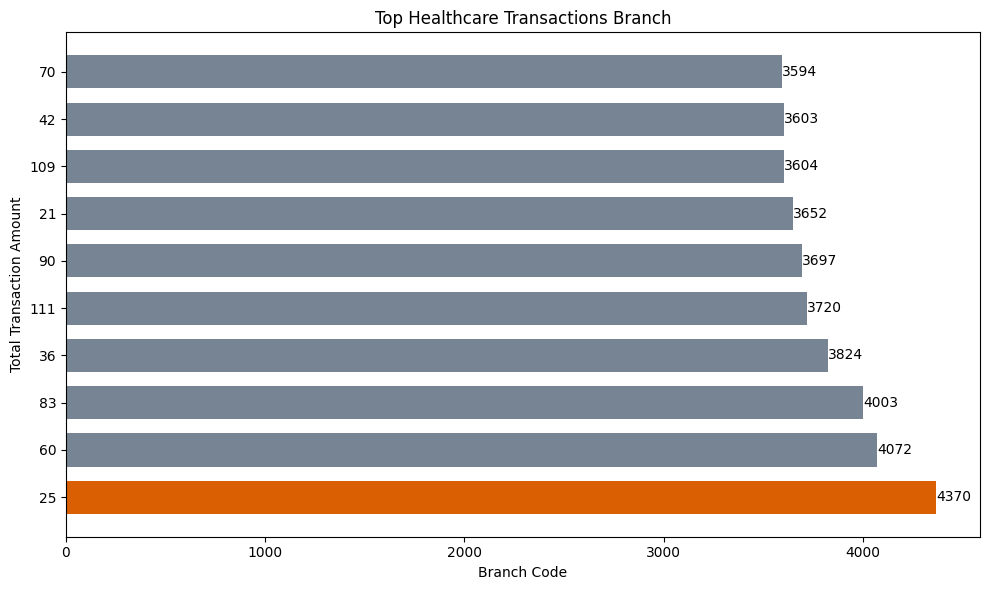

In [24]:
#topbranch= '25'
highlight_colour = '#d95f02'
non_highlight_colour = '#768493'

tophealthtransaction['colours'] = tophealthtransaction['BranchCode'].apply(lambda x: highlight_colour if x == tophealthtransaction['BranchCode'][0] else non_highlight_colour)
fig, ax = plt.subplots(figsize=(10,6))
g=ax.barh(tophealthtransaction['BranchCode'], tophealthtransaction['TotalTransactionAmount'],color=tophealthtransaction['colours'],height=0.7)
ax.set_xlabel("Branch Code")
ax.set_ylabel("Total Transaction Amount")
ax.bar_label(g, label_type="edge")
ax.set_yticks(list(tophealthtransaction['BranchCode']))
plt.title("Top Healthcare Transactions Branch")

plt.tight_layout()
plt.show()